### Installing MediaPipe

In [6]:
%%capture
!pip install mediapipe

### Required Libraries

In [7]:
import numpy as np
import os,cv2,math,glob,random
import scipy.io as sio
from math import cos, sin
from pathlib import Path
import pandas as pd
import mediapipe
import warnings
warnings.filterwarnings('ignore')
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import seaborn as sns

![image.png]()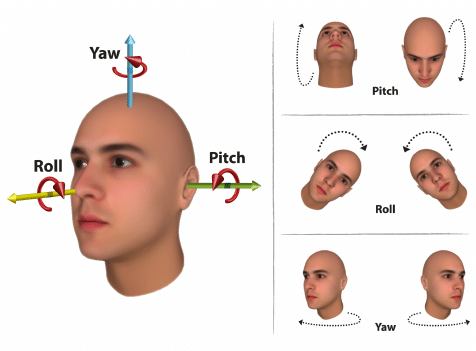

### Dowlining Data

In [8]:
# link of the data
# http://www.cbsr.ia.ac.cn/users/xiangyuzhu/projects/3DDFA/Database/AFLW2000-3D.zip

In [9]:
# Loading AFLW2000 Data
%%capture
if os.path.isfile('/content/AFLW2000-3D.zip') == False:
  !gdown --id  1fP3zvSCYjll_o_m7S12nvQLZ9MnsEoap
  !unzip /content/AFLW2000-3D.zip

In [10]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

### Preparing Data

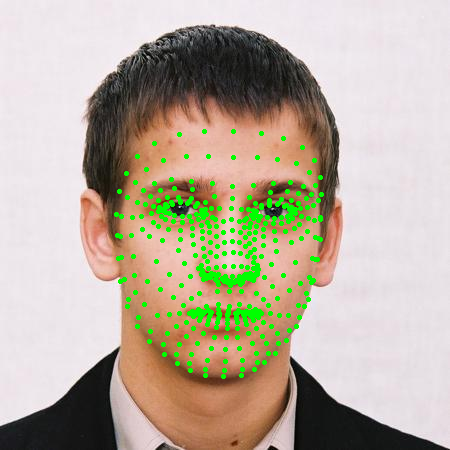

In [11]:
# choosing random image
random_file = 'image00053'

faceModule = mediapipe.solutions.face_mesh
# loading image and its correspinding mat file
with faceModule.FaceMesh(static_image_mode=True) as faces:
    # loading the image
    image = cv2.imread('/content/AFLW2000/'+random_file+'.jpg')
    # processing the face to extract the landmark points (468 point) for each x,y,z
    results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.multi_face_landmarks != None:
      # looping over the faces in the image
      for face in results.multi_face_landmarks:
          for landmark in face.landmark:
              x = landmark.x
              y = landmark.y
              # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
              shape = image.shape
              relative_x = int(x * shape[1])
              relative_y = int(y * shape[0])
              # cv2.putText(image, str(relative_y), (int(relative_x),int(relative_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,255,0), 2)
              cv2.circle(image, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
      cv2_imshow(image)

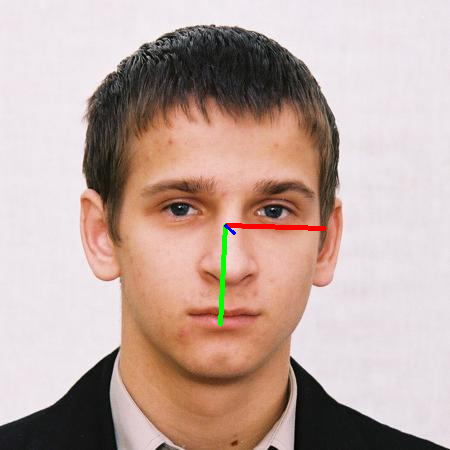

In [12]:
image = cv2.imread('/content/AFLW2000/'+random_file+'.jpg')
# loading the mat file to extract the 3 angels of the face (pitch,yaw,roll)
mat_file = sio.loadmat('/content/AFLW2000/'+random_file+'.mat')
# extracting the labels 3 angels
pose_para = mat_file["Pose_Para"][0][:3]
pitch = pose_para[0]
yaw = pose_para[1]
roll = pose_para[2]
cv2_imshow(draw_axis(image,pitch,yaw,roll))

### Data Preprocessing

In [13]:
def get_data(dir_path):
    landmarks = []
    angles = []
    with mediapipe.solutions.face_mesh.FaceMesh(static_image_mode=True) as face_mesh:
        for filename in sorted(os.listdir(dir_path)):
            if not filename.endswith('.jpg'):
                continue
            filepath = os.path.join(dir_path, filename)
            image = cv2.imread(filepath)
            results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            landmarks_per_image = []
            if results.multi_face_landmarks:
                for face_landmarks in results.multi_face_landmarks:
                    for landmark in face_landmarks.landmark:
                        x = landmark.x * image.shape[1]
                        y = landmark.y * image.shape[0]
                        landmarks_per_image.extend([int(x),int(y)])
            mat_filepath = os.path.join(dir_path, filename[:-4] + '.mat')
            pose_para = sio.loadmat(mat_filepath)["Pose_Para"][0][:3]
            landmarks.append(landmarks_per_image)
            angles.append(pose_para)
    return landmarks, angles

In [14]:
landmarks, angles = get_data('/content/AFLW2000')

In [15]:
df = pd.DataFrame(landmarks)
df.columns = [f'x{i//2}' if i%2==0 else f'y{i//2}' for i in range(len(df.columns))]
df[['Pitch', 'Yaw', 'Roll']] = angles
df.head()

,x0,y0,x1,y1,x2,y2,x3,y3,x4,y4,...,y464,x465,y465,x466,y466,x467,y467,Pitch,Yaw,Roll
0,218.0,309.0,220.0,287.0,220.0,291.0,215.0,253.0,220.0,279.0,...,221.0,243.0,225.0,299.0,212.0,304.0,208.0,-0.399231,0.018227,0.085676
1,198.0,288.0,187.0,266.0,201.0,274.0,196.0,245.0,187.0,259.0,...,230.0,225.0,231.0,263.0,225.0,267.0,222.0,0.470065,1.189533,0.300959
2,143.0,359.0,144.0,349.0,143.0,351.0,139.0,335.0,144.0,345.0,...,324.0,147.0,325.0,168.0,320.0,169.0,319.0,-0.184650,0.881137,-0.236852
3,226.0,312.0,211.0,294.0,220.0,296.0,199.0,265.0,207.0,286.0,...,229.0,220.0,233.0,268.0,205.0,271.0,200.0,-0.175379,0.299208,-0.373374
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.882169,1.198004,-1.033374


In [16]:
df.shape

(2000, 939)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Columns: 939 entries, x0 to Roll
dtypes: float64(939)
memory usage: 14.3 MB


### Missing Data

In [18]:
df.isna().sum()

x0       147
y0       147
x1       147
y1       147
x2       147
        ... 
x467     147
y467     147
Pitch      0
Yaw        0
Roll       0
Length: 939, dtype: int64

there are images that have no landmarks (features) in the data so the decision is to drop them

In [19]:
df = df.dropna()

In [20]:
df.isna().sum()

x0       0
y0       0
x1       0
y1       0
x2       0
        ..
x467     0
y467     0
Pitch    0
Yaw      0
Roll     0
Length: 939, dtype: int64

In [21]:
df.shape

(1853, 939)

In [22]:
df.describe()

,x0,y0,x1,y1,x2,y2,x3,y3,x4,y4,...,y464,x465,y465,x466,y466,x467,y467,Pitch,Yaw,Roll
count,1853.000000,1853.000000,1853.00000,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000,...,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000
mean,226.760389,299.274150,226.16082,274.486778,226.528332,281.919050,220.092283,247.431732,226.038316,266.358338,...,225.974096,238.417161,227.838100,278.986508,218.067998,282.784134,214.691311,-0.095366,0.013611,-0.033167
std,18.570710,12.759842,23.96623,13.076014,17.035913,11.103282,20.053886,10.755897,24.664709,12.890678,...,10.357402,15.265868,10.095854,21.373171,17.542719,22.569878,18.539862,0.549292,0.580266,0.649282
min,115.000000,80.000000,102.00000,65.000000,112.000000,68.000000,99.000000,45.000000,100.000000,59.000000,...,25.000000,120.000000,27.000000,137.000000,14.000000,132.000000,10.000000,-12.457202,-6.130066,-16.969362
25%,216.000000,293.000000,211.00000,269.000000,216.000000,277.000000,207.000000,243.000000,210.000000,261.000000,...,221.000000,231.000000,223.000000,266.000000,208.000000,270.000000,204.000000,-0.246453,-0.256714,-0.160274
50%,227.000000,300.000000,225.00000,276.000000,226.000000,283.000000,218.000000,248.000000,225.000000,268.000000,...,225.000000,239.000000,227.000000,281.000000,218.000000,285.000000,214.000000,-0.123371,0.019403,-0.017463
75%,236.000000,307.000000,241.00000,282.000000,236.000000,288.000000,232.000000,253.000000,242.000000,274.000000,...,231.000000,245.000000,233.000000,292.000000,227.000000,297.000000,224.000000,0.028133,0.305791,0.126460
max,417.000000,359.000000,418.00000,349.000000,415.000000,351.000000,405.000000,335.000000,416.000000,345.000000,...,324.000000,408.000000,325.000000,445.000000,333.000000,449.000000,337.000000,15.598820,3.277500,2.166107


each feature has different mean and std which doesn't equal to 0 and 1

In [23]:
X = df.iloc[:,:-3].copy()
y = df.iloc[:,-3:].copy()

In [24]:
X.head(2)

,x0,y0,x1,y1,x2,y2,x3,y3,x4,y4,...,x463,y463,x464,y464,x465,y465,x466,y466,x467,y467
0,218.0,309.0,220.0,287.0,220.0,291.0,215.0,253.0,220.0,279.0,...,251.0,218.0,246.0,221.0,243.0,225.0,299.0,212.0,304.0,208.0
1,198.0,288.0,187.0,266.0,201.0,274.0,196.0,245.0,187.0,259.0,...,235.0,228.0,230.0,230.0,225.0,231.0,263.0,225.0,267.0,222.0


In [25]:
y.head(2)

,Pitch,Yaw,Roll
0,-0.399231,0.018227,0.085676
1,0.470065,1.189533,0.300959


In [26]:
y.shape

(1853, 3)

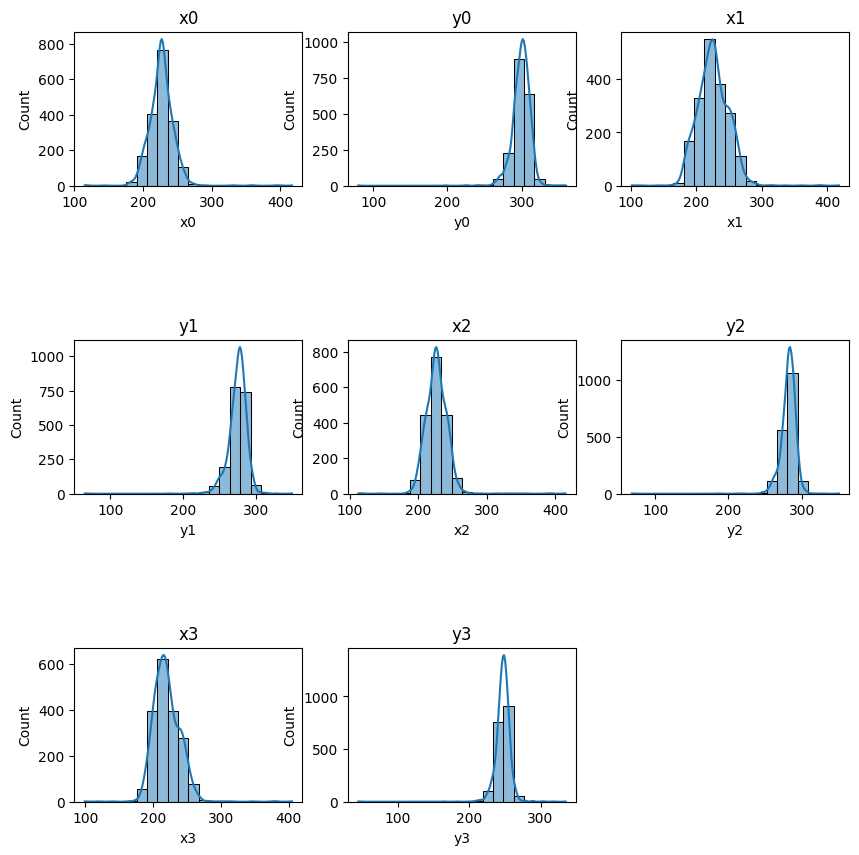

In [27]:
i = 1
plt.figure(figsize=(10, 10))
for column in X.columns.to_list()[:8]:
    plt.subplot(3, 3, i)
    i += 1
    sns.histplot(X[column], kde=True, bins=20)
    plt.title(column)
plt.subplots_adjust(hspace=1)
plt.show()

### Normalize
each image


In [28]:
l = [X.iloc[:,i] for i in range(len(X.columns)) if i%2==0 ]
X_df = pd.DataFrame(l).T
X_df.shape

(1853, 468)

In [29]:
X_df.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x458,x459,x460,x461,x462,x463,x464,x465,x466,x467
0,218.0,220.0,220.0,215.0,220.0,222.0,226.0,163.0,228.0,229.0,...,229.0,234.0,243.0,227.0,226.0,251.0,246.0,243.0,299.0,304.0
1,198.0,187.0,201.0,196.0,187.0,192.0,208.0,208.0,213.0,212.0,...,198.0,200.0,216.0,196.0,200.0,235.0,230.0,225.0,263.0,267.0
2,143.0,144.0,143.0,139.0,144.0,144.0,142.0,111.0,141.0,141.0,...,147.0,149.0,152.0,147.0,146.0,150.0,148.0,147.0,168.0,169.0
3,226.0,211.0,220.0,199.0,207.0,205.0,203.0,162.0,196.0,192.0,...,222.0,225.0,239.0,221.0,222.0,228.0,223.0,220.0,268.0,271.0
5,229.0,221.0,224.0,210.0,219.0,217.0,213.0,161.0,210.0,208.0,...,230.0,233.0,243.0,229.0,228.0,234.0,229.0,227.0,271.0,275.0


In [30]:
l = [X.iloc[:,i] for i in range(len(X.columns)) if i%2 !=0 ]
Y_df = pd.DataFrame(l).T
Y_df.head(2)

,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,...,y458,y459,y460,y461,y462,y463,y464,y465,y466,y467
0,309.0,287.0,291.0,253.0,279.0,265.0,228.0,203.0,201.0,189.0,...,288.0,285.0,286.0,289.0,290.0,218.0,221.0,225.0,212.0,208.0
1,288.0,266.0,274.0,245.0,259.0,251.0,230.0,225.0,214.0,206.0,...,269.0,268.0,274.0,270.0,272.0,228.0,230.0,231.0,225.0,222.0


In [31]:
Y_df.shape

(1853, 468)

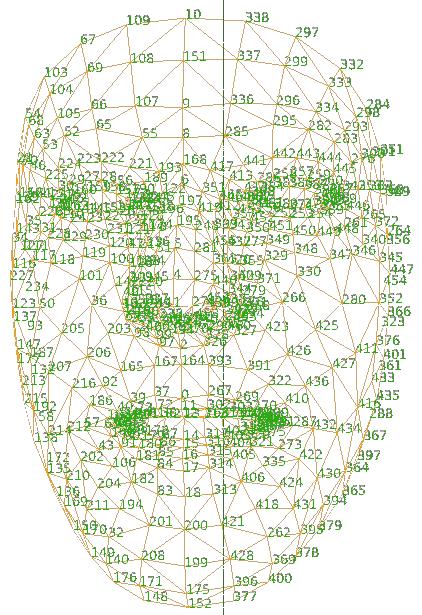

In [32]:
X[X_df.columns.to_list()] = (X_df - np.array(X.loc[:, 'x1']).reshape(-1, 1))
X[Y_df.columns.to_list()] = (Y_df - np.array(X.loc[:, 'y1']).reshape(-1, 1))
forehead = np.array([X.loc[:, 'x10'], X.loc[:, 'y10']]).T
chin = np.array([X.loc[:, 'x152'], X.loc[:, 'y152']]).T
forehead_chin = np.linalg.norm(chin - forehead, axis=1).reshape(-1, 1)
normalized_features = X / forehead_chin
normalized_features.head()

,x0,y0,x1,y1,x2,y2,x3,y3,x4,y4,...,x463,y463,x464,y464,x465,y465,x466,y466,x467,y467
0,-0.008347,0.091818,0.0,0.0,0.000000,0.016694,-0.020868,-0.141901,0.000000,-0.033388,...,0.129380,-0.287975,0.108512,-0.275455,0.095992,-0.258760,0.329711,-0.313017,0.350579,-0.329711
1,0.067483,0.134967,0.0,0.0,0.085888,0.049079,0.055214,-0.128832,0.000000,-0.042944,...,0.294473,-0.233124,0.263799,-0.220855,0.233124,-0.214720,0.466249,-0.251529,0.490788,-0.269934
2,-0.009802,0.098020,0.0,0.0,-0.009802,0.019604,-0.049010,-0.137229,0.000000,-0.039208,...,0.058812,-0.254853,0.039208,-0.245051,0.029406,-0.235249,0.235249,-0.284259,0.245051,-0.294061
3,0.073167,0.087801,0.0,0.0,0.043900,0.009756,-0.058534,-0.141457,-0.019511,-0.039023,...,0.082923,-0.336569,0.058534,-0.317058,0.043900,-0.297547,0.278036,-0.434126,0.292669,-0.458515
5,0.035103,0.127249,0.0,0.0,0.013164,0.039491,-0.048267,-0.122861,-0.008776,-0.039491,...,0.057043,-0.245723,0.035103,-0.232559,0.026327,-0.223783,0.219395,-0.302766,0.236947,-0.311541


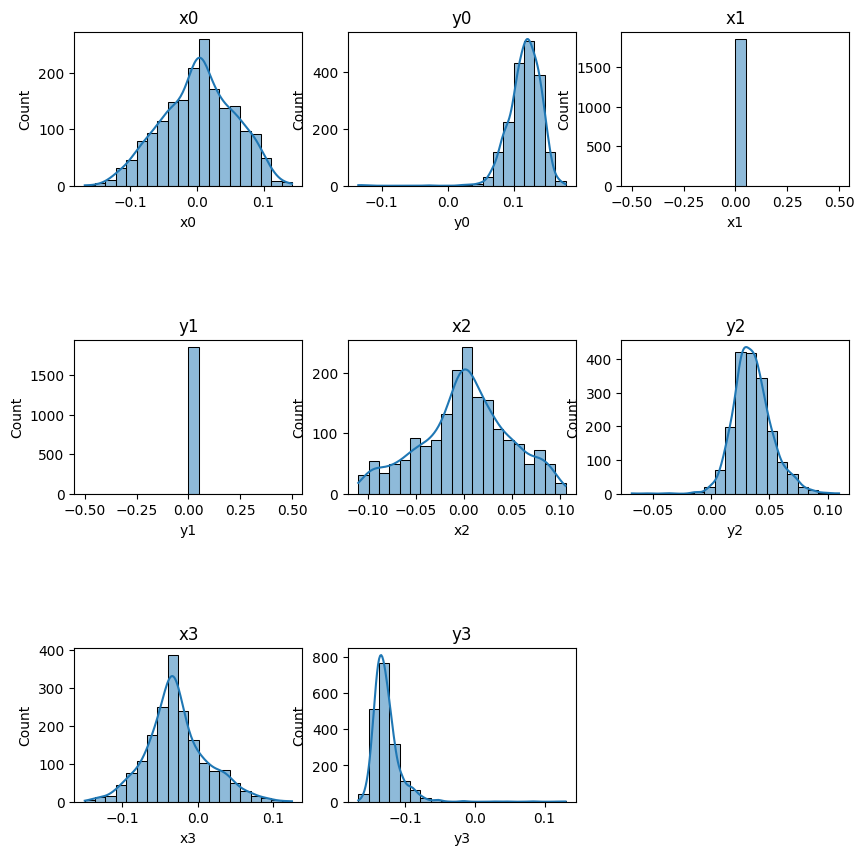

In [33]:
i = 1
plt.figure(figsize=(10, 10))
for column in normalized_features.columns.to_list()[:8]:
    plt.subplot(3, 3, i)
    i += 1
    sns.histplot(normalized_features[column], kde=True, bins=20)
    plt.title(column)
plt.subplots_adjust(hspace=1)
plt.show()

### Splitting data to train, test and validation

In [34]:
from sklearn.model_selection import train_test_split

In [35]:
X_train, X_test_val, y_train, y_test_val = train_test_split(normalized_features.values, y.values, test_size=0.3, random_state=42)

X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=42)

In [36]:
print(f'X_train:{X_train.shape}')
print(f'y_train:{y_train.shape}')
print(f'X_test:{X_test.shape}')
print(f'y_test:{y_test.shape}')
print(f'X_val:{X_val.shape}')
print(f'y_val:{y_val.shape}')

X_train:(1297, 936)
y_train:(1297, 3)
X_test:(278, 936)
y_test:(278, 3)
X_val:(278, 936)
y_val:(278, 3)


### Linear Regression


In [37]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [38]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [39]:
#scores on train
y_train_pred = model.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
print(f'train_mse:{train_mse}')
print(f'train_mae:{train_mae}')
print(f'train_r2:{train_r2}')

train_mse:0.05153138352222094
train_mae:0.15940656284130214
train_r2:0.8812799472669147


In [40]:
#scores on validation
y_val_pred = model.predict(X_val)
val_mse = mean_squared_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)
val_mae = mean_absolute_error(y_val, y_val_pred)
print(f'val_mse:{val_mse}')
print(f'val_mae:{val_mae}')
print(f'val_r2:{val_r2}')

val_mse:0.532375827338578
val_mae:0.5432426192226399
val_r2:-4.490510210171414


### lasso Regression


In [41]:
from sklearn.linear_model import Lasso

In [42]:
lasso_model = Lasso(alpha=0.0001, max_iter=10000)
lasso_model.fit(X_train, y_train)

Lasso(alpha=0.0001, max_iter=10000)

In [43]:
#scores on train
y_train_pred_lasso = lasso_model.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred_lasso)
train_r2 = r2_score(y_train, y_train_pred_lasso)
train_mae = mean_absolute_error(y_train, y_train_pred_lasso)
print(f'train_mse:{train_mse}')
print(f'train_mae:{train_mae}')
print(f'train_r2:{train_r2}')

train_mse:0.23062108009575377
train_mae:0.13620206843073476
train_r2:0.481621127244249


In [44]:
#scores on validation
y_val_pred_lasso = lasso_model.predict(X_val)
val_mse = mean_squared_error(y_val, y_val_pred_lasso)
val_r2 = r2_score(y_val, y_val_pred_lasso)
val_mae = mean_absolute_error(y_val, y_val_pred_lasso)
print(f'val_mse:{val_mse}')
print(f'val_mae:{val_mae}')
print(f'val_r2:{val_r2}')

val_mse:0.05275402065358261
val_mae:0.12258879617502544
val_r2:0.5459321346133553


### Ridge Regression


In [45]:
from sklearn.linear_model import Ridge

In [46]:
ridge_model = Ridge(alpha=0.01, max_iter=10000)
ridge_model.fit(X_train, y_train)

Ridge(alpha=0.01, max_iter=10000)

In [47]:
#scores on train
y_train_pred_ridge = lasso_model.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred_ridge)
train_r2 = r2_score(y_train, y_train_pred_ridge)
train_mae = mean_absolute_error(y_train, y_train_pred_ridge)
print(f'train_mse:{train_mse}')
print(f'train_mae:{train_mae}')
print(f'train_r2:{train_r2}')

train_mse:0.23062108009575377
train_mae:0.13620206843073476
train_r2:0.481621127244249


In [48]:
#scores on validation
y_val_pred_ridge = ridge_model.predict(X_val)
val_mse = mean_squared_error(y_val, y_val_pred_ridge)
val_r2 = r2_score(y_val, y_val_pred_ridge)
val_mae = mean_absolute_error(y_val, y_val_pred_ridge)
print(f'val_mse:{val_mse}')
print(f'val_mae:{val_mae}')
print(f'val_r2:{val_r2}')

val_mse:0.06929437151524227
val_mae:0.1558778529752643
val_r2:0.381656798793884


### decision tree


In [49]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats

In [50]:
decisiontree_model = DecisionTreeRegressor(min_samples_split=50, min_samples_leaf=20, random_state=42)
decisiontree_model.fit(X_train, y_train)

DecisionTreeRegressor(min_samples_leaf=20, min_samples_split=50,
                      random_state=42)

In [51]:
reg_tree = DecisionTreeRegressor(random_state=42)
multi_out_tree = MultiOutputRegressor(reg_tree)

random_search = RandomizedSearchCV(multi_out_tree, param_distributions= {
    'estimator__max_depth': np.arange(2, 10),
    'estimator__min_samples_split': np.logspace(1, 7, 7, base=2).astype(int),
    'estimator__min_samples_leaf': np.logspace(0, 6, 7, base=2).astype(int),
    'estimator__max_features': np.arange(4, 15),
    'estimator__ccp_alpha': scipy.stats.expon(scale=.1),
}, scoring='r2', n_iter=40, random_state=42)

random_search.fit(X_train, y_train)
decisiontree_model = random_search.best_estimator_


In [52]:
#scores on train
y_train_pred_tree = decisiontree_model.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred_tree)
train_r2 = r2_score(y_train, y_train_pred_tree)
train_mae = mean_absolute_error(y_train, y_train_pred_tree)
print(f'train_mse:{train_mse}')
print(f'train_mae:{train_mae}')
print(f'train_r2:{train_r2}')

train_mse:0.315044904821206
train_mae:0.20820152325032146
train_r2:0.29975355683808563


In [53]:
#scores on validation
y_val_pred_tree = decisiontree_model.predict(X_val)
val_mse = mean_squared_error(y_val, y_val_pred_tree)
val_r2 = r2_score(y_val, y_val_pred_tree)
val_mae = mean_absolute_error(y_val, y_val_pred_tree)
print(f'val_mse:{val_mse}')
print(f'val_mae:{val_mae}')
print(f'val_r2:{val_r2}')

val_mse:0.07970152854871264
val_mae:0.1802710159009211
val_r2:0.34012228254808724


### Random Forest


In [54]:
from sklearn.ensemble import RandomForestRegressor

In [55]:
reg_rf = RandomForestRegressor(random_state=42)
multi_out_rf = MultiOutputRegressor(reg_rf)

random_search = RandomizedSearchCV(multi_out_rf, param_distributions={
    'estimator__n_estimators': np.arange(10, 101, 10),
    'estimator__max_depth': np.arange(2, 10),
    'estimator__min_samples_split': np.logspace(1, 7, 7, base=2).astype(int),
    'estimator__min_samples_leaf': np.logspace(0, 6, 7, base=2).astype(int),
    'estimator__max_features': np.arange(4, 15),
    'estimator__ccp_alpha': scipy.stats.expon(scale=0.1),
}, scoring='r2', n_iter=40, random_state=42)

random_search.fit(X_train, y_train)
random_forest_model = random_search.best_estimator_

In [56]:
#scores on train
y_train_pred_tree = random_forest_model.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred_tree)
train_r2 = r2_score(y_train, y_train_pred_tree)
train_mae = mean_absolute_error(y_train, y_train_pred_tree)
print(f'train_mse:{train_mse}')
print(f'train_mae:{train_mae}')
print(f'train_r2:{train_r2}')

train_mse:0.25726639755611486
train_mae:0.12220849228442499
train_r2:0.4295439222991025


In [57]:
#scores on validation
y_val_pred_tree = random_forest_model.predict(X_val)
val_mse = mean_squared_error(y_val, y_val_pred_tree)
val_r2 = r2_score(y_val, y_val_pred_tree)
val_mae = mean_absolute_error(y_val, y_val_pred_tree)
print(f'val_mse:{val_mse}')
print(f'val_mae:{val_mae}')
print(f'val_r2:{val_r2}')

val_mse:0.046672880281698026
val_mae:0.1013788095724439
val_r2:0.5976387336559624


### SVR


In [58]:
from sklearn.svm import SVR

In [59]:
svr = SVR()
multi_out_svr = MultiOutputRegressor(svr)
random_search = RandomizedSearchCV(multi_out_svr, param_distributions = {
    'estimator__kernel': ['linear', 'poly', 'rbf'],
    'estimator__C': scipy.stats.expon(scale=2),
    'estimator__degree': np.arange(2, 6),
    'estimator__coef0': np.arange(0, 6),
    'estimator__gamma': scipy.stats.expon(scale=.1),
    'estimator__epsilon': scipy.stats.expon(scale=.1)
}, scoring='r2', random_state=42)
random_search.fit(X_train, y_train)
svr_model = random_search.best_estimator_
print('best parameters: ', random_search.best_params_)

best parameters:  {'estimator__C': 6.741260684922345, 'estimator__coef0': 1, 'estimator__degree': 3, 'estimator__epsilon': 0.03632878599687583, 'estimator__gamma': 0.010277731500250624, 'estimator__kernel': 'rbf'}


In [60]:
#scores on train
y_train_pred_svr = svr_model.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred_svr)
train_r2 = r2_score(y_train, y_train_pred_svr)
train_mae = mean_absolute_error(y_train, y_train_pred_svr)
print(f'train_mse:{train_mse}')
print(f'train_mae:{train_mae}')
print(f'train_r2:{train_r2}')

train_mse:0.2602081627378857
train_mae:0.08249909524553234
train_r2:0.4244399187778442


In [61]:
#scores on validation
y_val_pred_svr = svr_model.predict(X_val)
val_mse = mean_squared_error(y_val, y_val_pred_svr)
val_r2 = r2_score(y_val, y_val_pred_svr)
val_mae = mean_absolute_error(y_val, y_val_pred_svr)
print(f'val_mse:{val_mse}')
print(f'val_mae:{val_mae}')
print(f'val_r2:{val_r2}')

val_mse:0.03233042924411495
val_mae:0.06344884154832886
val_r2:0.7211439950293498


SVR got the best score so I will test it on test data

### testing


In [62]:
#scores on test
y_test_pred_svr = svr_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred_svr)
test_r2 = r2_score(y_test, y_test_pred_svr)
test_mae = mean_absolute_error(y_test, y_test_pred_svr)
print(f'train_mse:{test_mse}')
print(f'train_mae:{test_mae}')
print(f'train_r2:{test_r2}')

train_mse:0.0321092147562982
train_mae:0.07941712599349486
train_r2:0.788614530747747


### Testing on Images


In [77]:
def get_landmarks_image(image):
    faceModule = mediapipe.solutions.face_mesh
    landmarks = np.array([])
    with faceModule.FaceMesh(static_image_mode=True) as faces:
        # processing the face to extract the landmark points (468 point) for each x,y,z
        results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        if results.multi_face_landmarks:
            # extract x, y coordinates of all landmarks and scale to image dimensions
            landmarks = np.array([(lmk.x * image.shape[1], lmk.y * image.shape[0])
                                  for face in results.multi_face_landmarks
                                  for lmk in face.landmark]).flatten()
    return landmarks.reshape(1, -1)

In [64]:
def prediction(image_path):
    image = cv2.imread(image_path)
    features = get_landmarks_image(image)
    if features.size:
        features_df = pd.DataFrame(features, columns=X.columns)
        nose = np.array(list(zip(features_df['x1'], features_df['y1']))).squeeze()
        l = [features_df.iloc[:,i] for i in range(len(features_df.columns)) if i%2==0 ]
        X_df = pd.DataFrame(l).T
        l2 = [features_df.iloc[:,i] for i in range(len(features_df.columns)) if i%2 !=0 ]
        Y_df = pd.DataFrame(l2).T
        features_df[X_df.columns.to_list()] = (X_df - np.array(features_df.loc[:, 'x1']).reshape(-1, 1))
        features_df[Y_df.columns.to_list()] = (Y_df - np.array(features_df.loc[:, 'y1']).reshape(-1, 1))
        forehead = np.array([features_df.loc[:, 'x10'], features_df.loc[:, 'y10']]).T
        chin = np.array([features_df.loc[:, 'x152'], features_df.loc[:, 'y152']]).T
        forehead_chin = np.linalg.norm(chin - forehead, axis=1).reshape(-1, 1)
        normalized_features = features_df / forehead_chin

        y_pred = svr_model.predict(normalized_features.values).squeeze()

        img_pred = draw_axis(image.copy(), y_pred[0], y_pred[1], y_pred[2], tdx=nose[0],tdy=nose[1])

        return img_pred
    else:
        return None


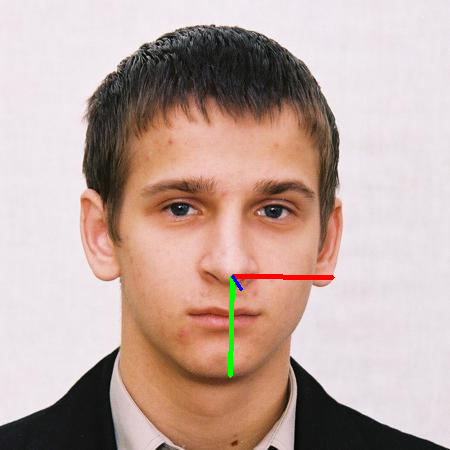

In [65]:
image_path = '/content/AFLW2000/image00053.jpg'
img_pred = prediction(image_path)
cv2_imshow(img_pred)

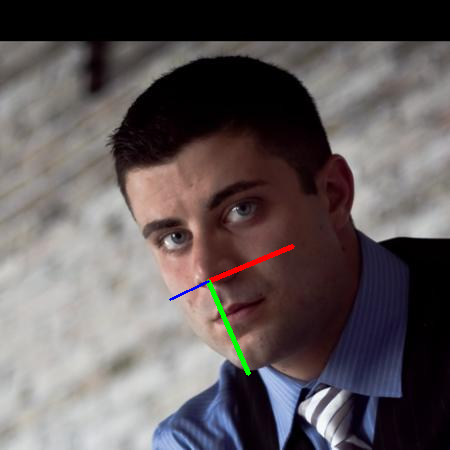

In [66]:
image_path = '/content/AFLW2000/image00020.jpg'
img_pred = prediction(image_path)
cv2_imshow(img_pred)

In [67]:
from google.colab import files

uploaded = files.upload()

Saving Dianaa.jpeg to Dianaa (1).jpeg


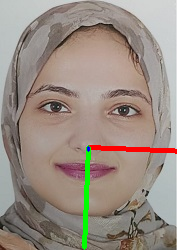

In [68]:
image_path = 'Dianaa.jpeg'
img_pred = prediction(image_path)
cv2_imshow(img_pred)

In [69]:
uploaded = files.upload()

Saving zoia.jfif to zoia (1).jfif


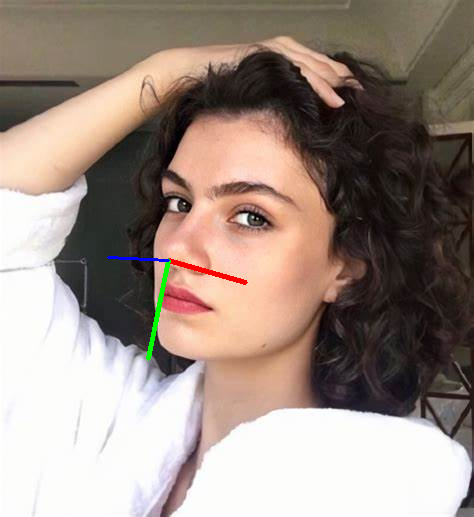

In [71]:
image_path = 'zoia.jfif'
img_pred = prediction(image_path)
cv2_imshow(img_pred)

### prediction on video


In [72]:
!pip install acapture

In [73]:
from google.colab import drive

In [74]:
uploaded = files.upload()

Saving luna.mp4 to luna (1).mp4


In [75]:
drive.mount('/content/gdrive')
drive_output_path = '/content/gdrive/MyDrive/luna_estimated.mp4'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [80]:
video_path = "luna.mp4"
cap = cv2.VideoCapture(video_path)
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
output_path = '/content/luna_estimated.mp4'
luna_estimated = cv2.VideoWriter(output_path,cv2.VideoWriter_fourcc(*'DIVX'), 20, (width,height))
while True:
    ret, frame = cap.read()
    if not ret:
        break

    features = get_landmarks_image(frame)
    if features.size:
        features_df = pd.DataFrame(features, columns=X.columns)
        nose = np.array(list(zip(features_df['x1'], features_df['y1']))).squeeze()
        l = [features_df.iloc[:,i] for i in range(len(features_df.columns)) if i%2==0 ]
        X_df = pd.DataFrame(l).T
        l2 = [features_df.iloc[:,i] for i in range(len(features_df.columns)) if i%2 !=0 ]
        Y_df = pd.DataFrame(l2).T
        features_df[X_df.columns.to_list()] = (X_df - np.array(features_df.loc[:, 'x1']).reshape(-1, 1))
        features_df[Y_df.columns.to_list()] = (Y_df - np.array(features_df.loc[:, 'y1']).reshape(-1, 1))
        forehead = np.array([features_df.loc[:, 'x10'], features_df.loc[:, 'y10']]).T
        chin = np.array([features_df.loc[:, 'x152'], features_df.loc[:, 'y152']]).T
        forehead_chin = np.linalg.norm(chin - forehead, axis=1).reshape(-1, 1)
        normalized_features = features_df / forehead_chin
        y_pred = svr_model.predict(normalized_features.values).squeeze()
        draw_axis(frame, y_pred[0], y_pred[1], y_pred[2], tdx=nose[0], tdy=nose[1])
        luna_estimated.write(frame)

luna_estimated.release()
cv2.destroyAllWindows()
!cp $output_path $drive_output_path
files.download(output_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>